# Quality control of gnomAD pedigrees

This notebook contains the QC of the gnomAD pedigrees.

The data was created as follows:
1. Pedigrees are inferred from the gnomAD kinship matrix produced by `pc_relate`. Threshold used were as follows:
    * First degree relatives:
        * parent/child: kin ~ [0.2, 0.4], k2 < 0.2
        * sibling: kin ~ [0.2, 0.4]
    * Parents:  kin < 0.05
2. For each duplicated sample, each trio is optimized for having all its samples coming from the same project
3. Pedigrees are merged with pedigrees from  previous fam file (_old_) (taking into account duplicate samples) and with a small set of "fake" trios generated by sampling 3 samples random samples into a trio.

The sections below contain the analyses to QC the trios created by
1. Looking at the differences between previous (_old_) and _new_ pedigrees. In particular at the reasons why some _old_ pedigrees are missing.
2. Looking at the distribution of Mendelian violations
3. Selecting a cutoff based on the number of z-scores above the mean of Mendelian violations

Based on the analyses below, the cutoff selected was 3 SD above the mean.

In [1]:
from gnomad_hail import *
from gnomad_hail.resources.sample_qc import *
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import random
from ggplot import *
from datetime import datetime

/opt/conda/lib/python3.6/site-packages/ggplot/utils.py:81: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  pd.tslib.Timestamp,
/opt/conda/lib/python3.6/site-packages/ggplot/stats/smoothers.py:4: FutureWarning: The pandas.lib module is deprecated and will be removed in a future version. These are private functions and can be accessed from pandas._libs.lib instead
  from pandas.lib import Timestamp
/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
# Uncomment to run Spark on locally
#hl.init(master='local[*]')

# Functions

In [217]:
def plot_mendel(
        ped_pd: pd.DataFrame,
        title : str = "",
        use_ggplot : bool = True
) -> None:
    """
    Plots histogram of MVs. #TODO: right now only useful in notebook -- should output a file

    :param DataFrame ped_pd: Dataframe with errors per sample and category
    :param data_type: One of "exomes" or "genomes"
    :param use_ggplot: If set use ggplot, otherwise use seaborn
    :return: None
    """

    # Plot with ggplot
    if use_ggplot:
        p = ggplot(ped_pd, aes("errors", fill="ped_name")) + \
            geom_histogram(binwidth=50) + facet_grid(x="ped_name", scales="free_y") + \
            ggtitle(title) + \
            theme_bw()
        print(p)

    # Plot with Seaborn
    else:
        plt.figure(title)
        names = set(ped_pd.ped_name)
        for ped_name in names:
            err = ped_pd.loc[ped_pd.ped_name == ped_name].errors
            sns.distplot(err, label=ped_name, bins=20, norm_hist=False, kde=False, hist=True)

        if title:
            plt.title(title)
        plt.legend()
        plt.show()

# Tag criteria for failing current family construction process
def get_fail_criteria(
    row: pd.Series
) -> str:
    """
    Takes a row from a trio metadata dataframe and outputs the reason(s) for failing to be considered a trio.
    
    :param DataFrame row: Input row
    :return: List of failing criteria
    :rtype: str
    
    """
    criteria = []
    if row.pat_mat_kin is not None and not np.isnan(row.pat_mat_kin) and row.pat_mat_kin >= 0.05:
        criteria.append('pat_mat_kin')
    if row.s_mat_kin is None or np.isnan(row.s_mat_kin) or row.s_mat_kin < 0.2 or row.s_mat_kin > 0.4:
        criteria.append('s_mat_kin')
    if row.s_mat_k2 is not None and not np.isnan(row.s_mat_k2) and row.s_mat_k2 > 0.2:
        criteria.append('s_mat_k2')
    if row.s_pat_kin is None or np.isnan(row.s_pat_kin) or row.s_pat_kin < 0.2 or row.s_pat_kin > 0.4:
        criteria.append('s_pat_kin')
    if row.s_pat_k2 is not None and not np.isnan(row.s_pat_k2) and row.s_pat_k2 > 0.2:
        criteria.append('s_pat_k2')
    if not row.is_female_mat:
        criteria.append('mat_not_female')
    if row.is_female_pat:
        criteria.append('pat_is_female')
    return ",".join(criteria)

def plot_errors_z_hist(
    ped_pd: pd.DataFrame,
    title: str = '',
    z_ped_name: str = 'new',
    vline: int = None
) -> None:
    """
    
    Plots a histogram of the z-scores above the mean of number of MVs per trio in the new data.
    Trios with z-scores below the mean are lumped at 0.
    
    :param DataFrame ped_pd: Input data
    :param str title: Plot title
    :param z_ped_name: Pedigree name for z-score computation (found in column `ped_name`)
    :param float vline: Position of vertical line to indicate cutoff
    :return: None
    
    """
    ped_pd_z = ped_pd[ped_pd.ped_name.str.contains(z_ped_name)].copy()
    mean_errors = np.mean(ped_pd_z.errors)
    std_errors = np.std(ped_pd_z.errors)
    ped_pd['z'] = ped_pd['errors'].apply(lambda x: 0 if x <= mean_errors else int(np.floor((x - mean_errors)/std_errors)))
    p = (ggplot(ped_pd, aes('z', fill='ped_name')) + 
          geom_histogram(binwidth=1) + 
          theme_bw() + 
          ggtitle(title) +
         scale_x_discrete(name='Z-score above the mean'))
    if vline is not None:
        p + geom_vline(x=[vline], linetype='dashed')
    print(p)

# Exomes

In [63]:
# Load exomes data
exomes_ped_pd = hl.read_table(merged_pedigrees_ht_path('exomes')).to_pandas()
exomes_ped_pd.describe()

,errors,snp_errors,pat_mat_k2,pat_mat_kin,s_mat_k2,s_mat_kin,s_pat_k2,s_pat_kin
count,6735.00000,6735.000000,10.000000,10.000000,6112.000000,6112.000000,6109.000000,6109.000000
mean,529.55412,403.521455,0.033107,0.066521,0.033424,0.241869,0.033285,0.242041
std,636.52322,590.349593,0.011305,0.008810,0.015283,0.006813,0.015429,0.006842
min,192.00000,111.000000,0.017450,0.054315,-0.020451,0.222591,-0.018615,0.217542
25%,294.50000,187.000000,0.025265,0.058147,0.023122,0.237588,0.023167,0.237731
50%,331.00000,215.000000,0.031660,0.069400,0.033324,0.241456,0.032725,0.241585
75%,383.00000,264.000000,0.040078,0.071451,0.042661,0.245475,0.042742,0.245559
max,4669.00000,4169.000000,0.050087,0.081835,0.150029,0.301394,0.138312,0.297094


In [215]:
#Overall exomes counts by group
exomes_ped_pd.groupby('ped_name').apply(lambda df: pd.Series({'n': len(df)}))

,n
ped_name,
fake,609
new,4139
"new,old",1954
old,33


/opt/conda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


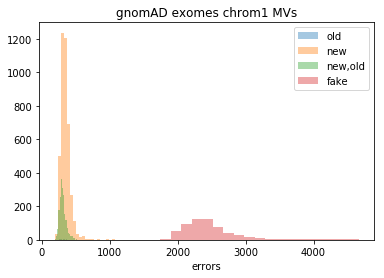

In [120]:
# Plot exomes Mendel errors histogram
plot_mendel(exomes_ped_pd, title='gnomAD exomes chrom1 MVs', use_ggplot=False)

In [64]:
# Evaluate why exomes trios from previous iteration were not included
exomes_old_pd = exomes_ped_pd[exomes_ped_pd.ped_name == 'old'].copy()
exomes_old_pd['fail_criteria'] = exomes_old_pd.apply(get_fail_criteria, axis=1)
exomes_old_pd.groupby('fail_criteria').apply(lambda df: pd.Series({'n': len(df)}))


,n
fail_criteria,
"mat_not_female,pat_is_female",3
pat_mat_kin,9
"pat_mat_kin,s_mat_kin,s_pat_kin",1
s_mat_kin,4
"s_mat_kin,s_pat_kin",7
"s_mat_kin,s_pat_kin,pat_is_female",2
s_pat_kin,6
"s_pat_kin,pat_is_female",1


As displayed in this table, the most common reason for _old_ exomes families to be missing on the new pedigreeis that one of both parents do not have a `kin` value corresponding to a 1st degree relative in our data ([0.2, 0.4]).
There are also 9 instances (`pat_mat_kin`), where parents are related with a `kin` > 0.05. 
Finally, there are 3 families where the father and mother were swapped in our previous release.

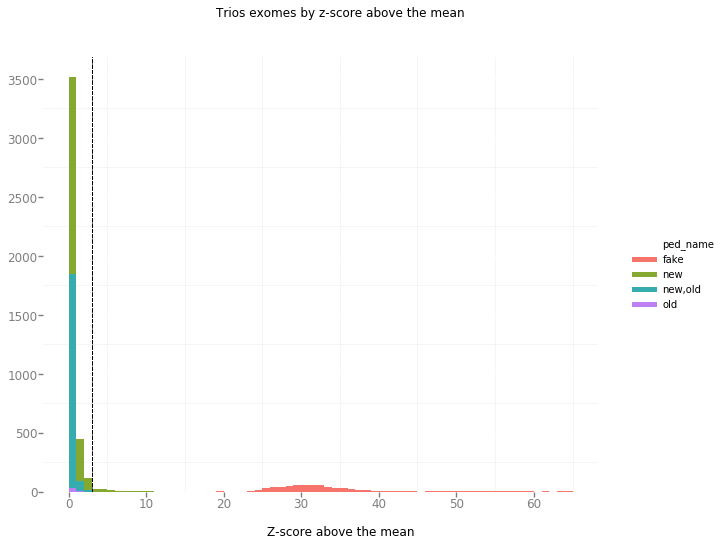

<ggplot: (-9223363265451394230)>


In [214]:
# Look at number of genomes filtered based on MVs
plot_errors_z_hist(exomes_ped_pd,
                   'Trios exomes by z-score above the mean',
                  vline=3)

# Genomes

In [114]:
# Load genomes data
genomes_ped_pd = hl.read_table(merged_pedigrees_ht_path('genomes')).to_pandas()
genomes_ped_pd.describe()

,errors,snp_errors,pat_mat_k2,pat_mat_kin,s_mat_k2,s_mat_kin,s_pat_k2,s_pat_kin
count,820.000000,820.000000,24.000000,24.000000,748.000000,748.000000,748.000000,748.000000
mean,48396.096341,28795.624390,0.037734,0.080349,0.036306,0.244351,0.035908,0.244561
std,50686.573927,42147.193077,0.014700,0.022570,0.023675,0.011216,0.020709,0.010811
min,15937.000000,8130.000000,0.016850,0.051888,-0.014078,0.228233,-0.005926,0.217848
25%,29203.000000,14004.500000,0.025799,0.062787,0.023834,0.238768,0.024160,0.238908
50%,34221.000000,16067.500000,0.036333,0.073554,0.034077,0.242151,0.033542,0.242947
75%,40110.000000,18952.500000,0.045265,0.098032,0.043517,0.246551,0.044154,0.246530
max,301572.000000,232639.000000,0.080613,0.121703,0.231225,0.324058,0.186237,0.325400


In [216]:
#Overall genomes counts by group
genomes_ped_pd.groupby('ped_name').apply(lambda df: pd.Series({'n': len(df)}))

,n
ped_name,
fake,72
new,336
"new,old",388
old,24


/opt/conda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


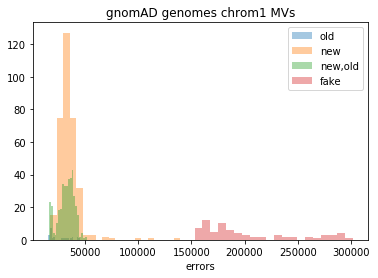

In [119]:
# Plot genomes mendelian violations histogram
plot_mendel(genomes_ped_pd, title='gnomAD genomes chrom1 MVs', use_ggplot=False)

In [117]:
# Evaluate why genomes trios from previous iteration were not included
genomes_old_pd = genomes_ped_pd[genomes_ped_pd.ped_name == 'old'].copy()

genomes_old_pd['fail_criteria'] = genomes_old_pd.apply(get_fail_criteria, axis=1)

genomes_old_pd.groupby('fail_criteria').apply(lambda df: pd.Series({'n': len(df)}))


,n
fail_criteria,
pat_mat_kin,23
"pat_mat_kin,s_mat_k2",1


For genomes, the most common reason for _old_ families missing is that the father and mother are related (`kin` > 0.05)

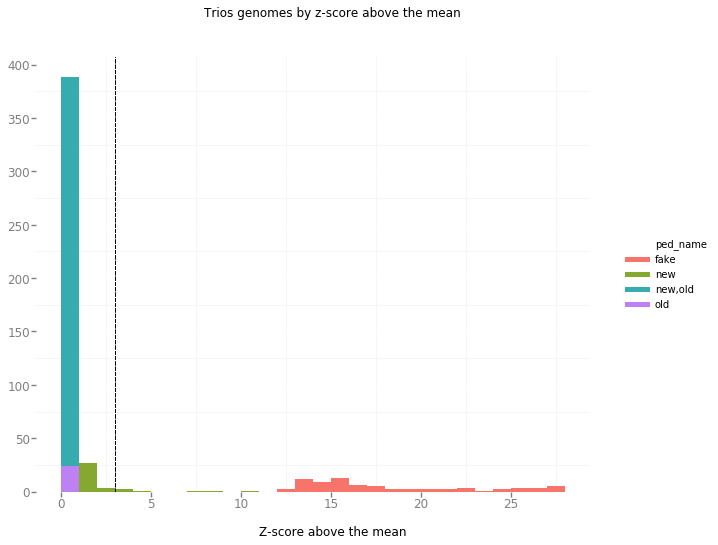

<ggplot: (-9223363265450645816)>


In [212]:
# Look at number of genomes filtered based on MVs
plot_errors_z_hist(genomes_ped_pd,
                   'Trios genomes by z-score above the mean',
                  vline=3)

# Conclusion

This method works well for identifying trios, with the unavoidable caveat of having to pick thresholds on `kin` (pi_hat / 2) and `k2` (ibd2). Although no extensive search for optimal parameters was done, 
the relatively conservative values used seem to work well since ~98.5% of previous exomes families and ~94.2% of previous genomes families are re-identified.

As for post-QC threshold, 3 SD above the mean of Mendelian violations seems to provide a reasonable threshold to remove outlier families.
